In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

In [2]:
def add_quiet_zone(qr_img, border_size = 20):
    height, width = qr_img.shape
    new_img = np.full((height + 2*border_size, width + 2*border_size), 255, dtype=np.uint8)
    new_img[border_size:border_size + height, border_size:border_size + width] = qr_img
    
    return new_img

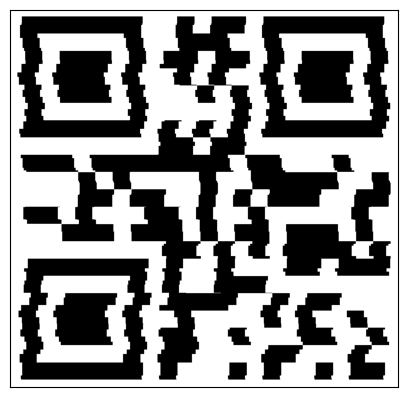

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the new image and convert to grayscale
img_path = "05-Caesar-cipher.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Adjust the binarization threshold to improve quiet zone detection
_, img_binary = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

# Reinitialize the start and end positions for rows and columns
start_row = -1
start_col = -1
end_row = -1
end_col = -1

# Find the first black pixel in each row and column to set boundaries
# Find start row
for row_index in range(img_binary.shape[0]):
    if any(img_binary[row_index] < 255):
        start_row = row_index
        break

# Find end row
for row_index in range(img_binary.shape[0] - 1, -1, -1):
    if any(img_binary[row_index] < 255):
        end_row = row_index + 1
        break

# Find start column
for col_index in range(img_binary.shape[1]):
    if any(img_binary[:, col_index] < 255):
        start_col = col_index
        break

# Find end column
for col_index in range(img_binary.shape[1] - 1, -1, -1):
    if any(img_binary[:, col_index] < 255):
        end_col = col_index + 1
        break

# Check if the boundaries are valid
if (start_row >= 0 and end_row > start_row) and (start_col >= 0 and end_col > start_col):
    # Crop the image using the detected boundaries
    qr_no_quiet_zone = img_binary[start_row:end_row, start_col:end_col]

    qr_with_quiet_zone = add_quiet_zone(qr_no_quiet_zone, 20)

    # Display the QR code without the quiet zone
    fig = plt.figure(figsize=(5, 5))
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.title("QR code with quiet zone")
    #plt.imshow(qr_no_quiet_zone, cmap="gray")
    plt.imshow(qr_with_quiet_zone, cmap="gray")  # Display the corrected image
else:
    print("Error: Could not find valid boundaries. Please check the image or preprocessing.")

(21, 21)


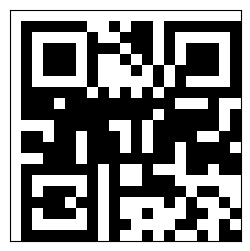

In [4]:
img = cv2.imread("05-Caesar-cipher.png", cv2.IMREAD_GRAYSCALE)

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    if (row != 255).any():
        start_row = row_index
        break

for row_index, row in enumerate(img[::-1]):
    if (row != 255).any():
        end_row = img.shape[0] - row_index
        break

for col_index, col in enumerate(cv2.transpose(img)):
    if (col != 255).any():
        start_col = col_index
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    if (col != 255).any():
        end_col = img.shape[1] - col_index
        break

img_no_quiet_zone = img[start_row:end_row, start_col:end_col]

img_21x21_grid = cv2.resize(img_no_quiet_zone, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_21x21_grid, cmap='gray');
print(img_21x21_grid.shape)

In [5]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [6]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [7]:
img_21x21_grid_inv = 1 - img_21x21_grid
ecl = img_21x21_grid_inv[8, 0:2]
mask = img_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [0 1]
MASK = [1 1 0]
ENC = [1, 0, 1, 1]
LEN = [1, 0, 0, 0, 1, 0, 0, 0] = 136 data symbols, each consisting of 8 bits


In [8]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [9]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1
# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1
# Let's see what the bytes that follow look like
# There supposedly remain 25-len-1 bytes to be read
for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

10010110 (=150) = 
00100110 (=038) = &
00011001 (=025) = 
10100011 (=163) = £
01011011 (=091) = [
11000101 (=197) = Å
00101101 (=045) = -
11101001 (=233) = é
10110101 (=181) = µ
11011100 (=220) = Ü
10111001 (=185) = ¹
00001000 (=008) =
10101101 (=173) = ­
00011111 (=031) = 
01110111 (=119) = w
10100101 (=165) = ¥
00001010 (=010) = 

1001 (=009) = 	
10001100 (=140) = 
11110011 (=243) = ó
11001111 (=207) = Ï
11100111 (=231) = ç
11011011 (=219) = Û
01010101 (=085) = U
11000011 (=195) = Ã


IndexError: list index out of range